In [1]:
import os

from pathlib import Path

import matplotlib.pyplot as plt

from lhotse.augmentation import WavAugmenter
from lhotse.cut import CutSet
from lhotse.dataset.speech_recognition import SpeechRecognitionDataset
from lhotse.features import Fbank, FeatureSetBuilder
from lhotse.recipes.mini_librispeech import download_and_untar, prepare_mini_librispeech
from lhotse import LilcomFilesWriter

# Settings for paths

In [2]:
root_dir = Path('data')
corpus_dir = root_dir / 'LibriSpeech'
output_dir = root_dir / 'mini_librispeech_nb'

# Download and untar

In [3]:
download_and_untar(root_dir)

# Prepare audio and supervision manifests

In [4]:
mini_librispeech_manifests = prepare_mini_librispeech(corpus_dir, output_dir)

# [Optional] Data augmentation

In [5]:
use_data_augmentation = True
augmenter = WavAugmenter.create_predefined('pitch_reverb_tdrop', sampling_rate=16000) if use_data_augmentation else None
# It seems when spawning multiple Python subprocesses with the same sox handle it raises "std::runtime_error: Couldn't close file"
# The issue seems to happen only in a Jupyter notebook on Mac OS X, hence the work around below.
num_jobs = 1 if use_data_augmentation else os.cpu_count()

# Extract features

In [6]:
for partition, manifests in mini_librispeech_manifests.items():
    with LilcomFilesWriter(f'{output_dir}/feats_{partition}') as storage:
        feature_set_builder = FeatureSetBuilder(
            feature_extractor=Fbank(),
            storage=storage,
            augmenter=augmenter
        )
        feature_set = feature_set_builder.process_and_store_recordings(
            recordings=manifests['audio'],
            num_jobs=os.cpu_count()
        )
    mini_librispeech_manifests[partition]['feats'] = feature_set

    cut_set = CutSet.from_manifests(supervisions=manifests['supervisions'], features=feature_set)
    mini_librispeech_manifests[partition]['cuts'] = cut_set
    cut_set.to_json(output_dir / f'cuts_{partition}.json.gz')

# Make pytorch Dataset

In [7]:
cuts_dev = SpeechRecognitionDataset(mini_librispeech_manifests['dev-clean-2']['cuts'])
cuts_train = SpeechRecognitionDataset(mini_librispeech_manifests['train-clean-5']['cuts'])

# Illustation of an example

IF THE READER WILL EXCUSE ME I WILL SAY NOTHING OF MY ANTECEDENTS NOR OF THE CIRCUMSTANCES WHICH LED ME TO LEAVE MY NATIVE COUNTRY THE NARRATIVE WOULD BE TEDIOUS TO HIM AND PAINFUL TO MYSELF


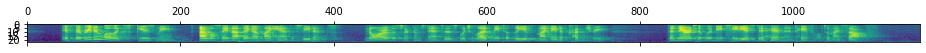

In [8]:
sample = cuts_dev[0]
print(sample['text'])
plt.matshow(sample['features'].transpose(0, 1).flip(0))